In [1]:
from networkx import nx
import random
import importlib
import math
import numpy as np
from itertools import count
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm

import collections
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F


In [2]:
class World:
    
    def __init__(self,n,m,agents):
        self.graph  = nx.triangular_lattice_graph(n,m) # NetworkX grpah defining the world space
        self.agents = agents                           # List of agents in the world
        # location of the agents are set randomly on the graph
#         for agent in agents:
#             t = random.choice(range(0,len(self.graph.nodes())))
#             agent.set_location( list( self.graph.nodes() )[t] )
        self.agents[0].set_location((1,1))      

    def get_graph(self):
        return self.graph
                    
    def add_agent(self,agent):
        self.agents.append(agent)            # Add a new agent in the world
        # Set its location randomly on the graph
        t = random.choice(range(0,len(self.graph.nodes())))
        agent.set_location(list(G.nodes())[t])
        
    def next_state(self):
        for agent in self.agents:
            agent.act(self)   
            
class Agent:
    
    def __init__(self,name,role,location=None):
        self.name     = name      # Name(string of three letters)
        self.role     = role      # Evader or Pursuer('evader' or 'pursuer')
        self.location = location  # Location on Graph(node of the graph) (a tuple)
        
    def get_location(self):
        return self.location
    
    def get_role(self):
        return self.role
    
    def get_name(self):
        return self.name
    
    def set_location(self,location):
        self.location = location
              
class Environment():
    
    # Two agent environment
    def __init__(self, agents, n, m):
        self.agents = agents # list of Agents
        self.World = World(n, m, agents)
        self.state = ()
        for agent in self.agents:
            self.state = self.state + agent.get_location()

    def reset(self):
        self.World = World(n, m, self.agents)
        self.state = ()
        for agent in self.agents:
            self.state = self.state + agent.get_location()
            
    def get_state(self):
        return torch.from_numpy(np.asarray(self.state)).unsqueeze(0)
        
    def step(self, action): # Action is a 2-item list 
        
        for i in range(1):
            agent =  self.agents[i]
            loc = agent.get_location()
            g = list( self.World.get_graph().neighbors(loc) )
            if len(g) <= action: # Right now, evader is considered to be stationary
                continue
            else:
                self.agents[i].set_location(g[action])
                
        self.state = ()
        for agent in self.agents:
            self.state = self.state + agent.get_location()
            
        if self.agents[0].get_location() == self.agents[1].get_location() : 
            done = True
            reward = 0
            return done, reward
    
        else:
            done = False
            reward = -1
            return done, reward
        

In [6]:
class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(4, 30) 
#         self.bn1 = nn.BatchNorm1d(30)
        self.fc2 = nn.Linear(30, 15)
#         self.bn2 = nn.BatchNorm1d(15)
        self.fc3 = nn.Linear(15, outputs)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

Transition = collections.namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

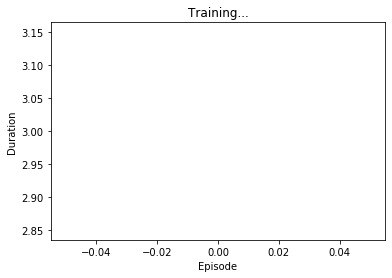

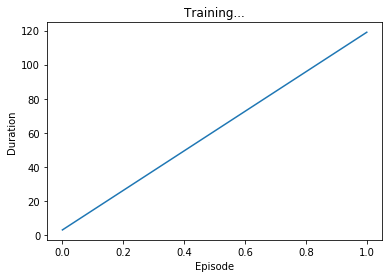

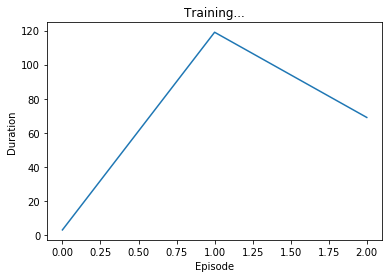

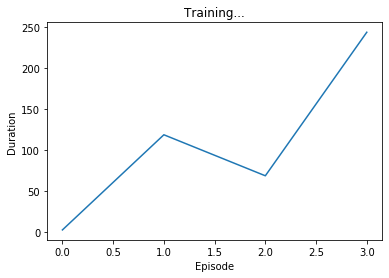

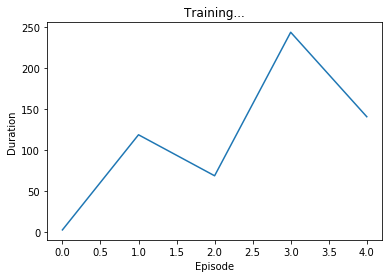

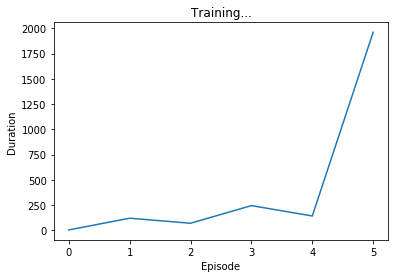

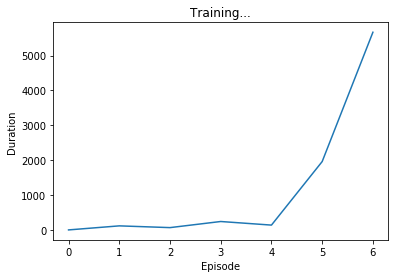

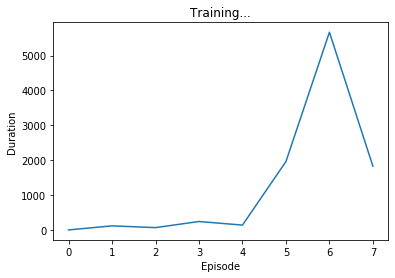

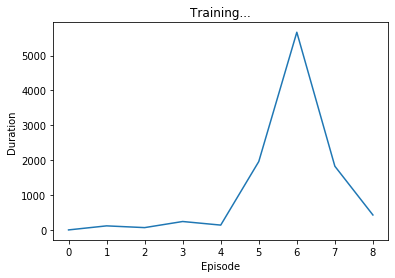

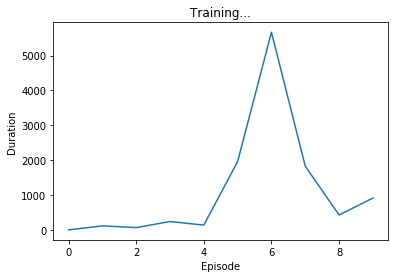

In [ ]:
##Set Variables
n = 10
m = 10

a = Agent('chi','pursuer')
b = Agent('nav','evader')

env = Environment([a, b], n, m)


# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Set number of actions
n_actions = 6

# Double DQN
policy_net = DQN(n_actions).to(device) # Policy Network
target_net = DQN(n_actions).to(device) # Target Network
policy_net = policy_net.double()
target_net = target_net.double()

# Set Policy Net to Target Net initially
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Set optimizer method
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            state = state.type(torch.DoubleTensor)
            e = policy_net(state).argmax()
            return torch.tensor([[e]])
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),                                   device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch  = state_batch.type(torch.DoubleTensor)
    reward_batch = reward_batch.type(torch.DoubleTensor)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    non_final_next_states = non_final_next_states.type(torch.DoubleTensor)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach().type(torch.FloatTensor)
    expected_state_action_values = (next_state_values.type(torch.DoubleTensor) * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()



num_episodes = 500
for i_episode in range(num_episodes):
#     print("Episode No. : " +str(i_episode))
    env.reset()
    state = env.get_state()
    
    
    for t in count():     
        action = select_action(state)
        done, reward = env.step(action.item())
        reward = torch.tensor([[reward]], device=device)

        if not done:
            next_state = env.get_state()
        else:
            next_state = None


        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
plt.ioff()
plt.show()

In [8]:
import matplotlib
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# plt.ion()
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.002)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
        
